In [1]:
import xarray as xr
import climtas.io
import dask
import numpy as np
import sys
sys.path.append('/home/563/rl5183/PhD-research/Functions')
import functions as func
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

In [2]:
import dask.distributed
import tempfile
tempdir = tempfile.TemporaryDirectory("dask-worker-space")
dask.distributed.Client(local_directory=tempdir.name, memory_limit='16gb')

Client Scheduler: tcp://127.0.0.1:43847 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 44.92 GiB


In [3]:
temp_data_dt = xr.open_dataarray('/g/data/w40/rl5183/progress_files/TXx_detrended.nc', chunks={'member':1, 'time':-1, 'lat':110, 'lon':110}).sel(time=slice('1901-11', '2015-10'))

In [4]:
temp_data_dt

,Array,Chunk
Bytes,52.84 GiB,126.29 MiB
Shape,"(80, 1368, 180, 360)","(1, 1368, 110, 110)"
Count,1281 Tasks,640 Chunks
Type,float64,numpy.ndarray


### Open HadISST dataset

In [4]:
hadisst_ds = xr.open_dataset('/g/data/eg3/jxb548/OBSDATA/hadisstv1.1870_2017.nc')
sst_data = hadisst_ds.sst

In [5]:
# Detrend HadISST data
sst_data_detrend = np.apply_along_axis(func.detrend_2step, 0, sst_data)
sst_detrended = xr.DataArray(sst_data_detrend, coords=sst_data.coords, attrs=sst_data.attrs)

In [6]:
# Nino3.4 index with HadiSSTv1
nino34_region = sst_detrended.sel(latitude=slice(5,-5), longitude=slice(-170,-120))
climatology = nino34_region.sel(time=slice('1950-01','1979-12')).groupby('time.month').mean()
monthly_anomalies = (nino34_region.groupby('time.month')-climatology).mean(dim=['latitude','longitude'])
monthly_anomalies_rolling = monthly_anomalies.rolling(time=5).mean()
sst_std = nino34_region.sel(time=slice('1950-01','1979-12')).std()
nino34_index = monthly_anomalies_rolling.sel(time=slice('1901-11', '2015-10'))/sst_std

In [7]:
# Take the mean over every quarter
quarterly_nino = nino34_index.resample(time='QS-NOV').mean('time')

# Select out NDJ nino34 index
nino_ndj = quarterly_nino.isel(time=slice(0,None,4))

In [8]:
def ensemble_correlation(data, nino):
    
    # Take max over every quarter 
    quarterly_data = data.resample(time='QS-NOV').max('time')

    # Calculate instantaneous regression 
    quarterly_correlation = func.correlate_nino_by_month(quarterly_data, nino)
    
    return quarterly_correlation

In [9]:
%%time 
correlation_list = []
for m in temp_data_dt.member:
    correlation_list.append(ensemble_correlation(temp_data_dt.sel(member=m), nino_ndj))

CPU times: user 2h 48min 58s, sys: 21min 22s, total: 3h 10min 21s
Wall time: 3h 20min 29s


In [10]:
correlations = xr.concat(correlation_list, dim='member')

In [11]:
correlations

<xarray.DataArray (member: 80, month: 4, lat: 180, lon: 360)>
array([[[[ 0.12413788,  0.12520565,  0.1245912 , ...,  0.12696465,
           0.12557893,  0.12414444],
         [ 0.10088981,  0.1006335 ,  0.10036624, ...,  0.10118139,
           0.10072043,  0.10022361],
         [ 0.09666462,  0.09581449,  0.09498956, ...,  0.09869011,
           0.09718932,  0.09745033],
         ...,
         [-0.03818854, -0.04152322, -0.04514152, ..., -0.02510958,
          -0.03042566, -0.03493503],
         [-0.03256963, -0.03574189, -0.03886458, ..., -0.02291334,
          -0.02626298, -0.02956988],
         [-0.01056804, -0.01181798, -0.0120233 , ..., -0.00849278,
          -0.00936829, -0.00984759]],

        [[ 0.11021321,  0.11258716,  0.11320012, ...,  0.10761493,
           0.10828584,  0.10956948],
         [ 0.12819728,  0.12932435,  0.13146437, ...,  0.12315257,
           0.12461372,  0.12631467],
         [ 0.11556893,  0.1159566 ,  0.11950137, ...,  0.11521626,
           0.1148428 ,  0.11557271],
...
         [-0.09959096, -0.09941978, -0.09922631, ..., -0.09081278,
          -0.09422521, -0.09657892],
         [-0.13815312, -0.14013972, -0.14280808, ..., -0.12821768,
          -0.13119484, -0.13431277],
         [-0.14681638, -0.14636418, -0.14810966, ..., -0.14560093,
          -0.14604226, -0.14674048]],

        [[-0.21682827, -0.21776472, -0.21916095, ..., -0.21378194,
          -0.21461859, -0.21528531],
         [-0.2286927 , -0.22864826, -0.22951421, ..., -0.22500294,
          -0.22597161, -0.22726092],
         [-0.19768401, -0.19729701, -0.19799696, ..., -0.1930744 ,
          -0.19476792, -0.19731059],
         ...,
         [ 0.10773537,  0.11165456,  0.11554301, ...,  0.09420455,
           0.09919843,  0.10300484],
         [ 0.08511815,  0.08623913,  0.08735664, ...,  0.08064398,
           0.08206671,  0.08385737],
         [ 0.05156614,  0.05141358,  0.05181758, ...,  0.05071721,
           0.05092757,  0.05165801]]]])
Coordinates:
  * member   (member) int64 1 2 3 4 5 6 7 8 9 10 ... 72 73 74 75 76 77 78 79 80
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * month    (month) int64 2 5 8 11

In [12]:
# Save as netcdf
correlations.to_netcdf('/g/data/w40/rl5183/20CR/temp/TXx_correlations_all_members_1901_2015.nc')

In [2]:
correlations = xr.open_dataarray('/g/data/w40/rl5183/20CR/temp/TXx_correlations_all_members_1901_2015.nc')

/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/local/eg3/rl5183/tmp/ipykernel_2449559/94580692.py:21: MatplotlibDeprecationWarning: 
The 'quality' parameter of print_jpg() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use pil_kwargs={'quality': ...} instead. If any parameter follows 'quality', they should be passed as keyword, not positionally.
  plt.savefig('ensemble_mean_corr_txx.jpg', bbox_inches='tight', dpi=300, qualit

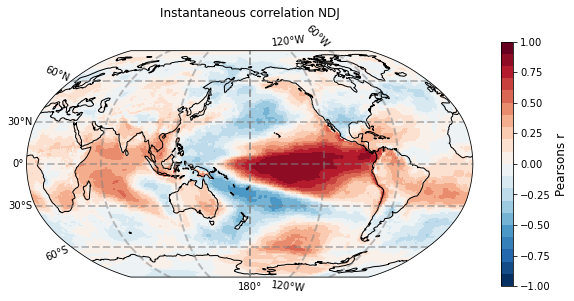

In [3]:
# Plot ensemble mean to check 
fig = plt.figure(figsize=(10,5))

vmin=-1
vmax=1

ax = fig.add_subplot(111, projection=ccrs.Robinson(180))
C = correlations.sel(month=11).mean(dim='member').plot(ax=ax, vmin=vmin, vmax=vmax, add_colorbar=False, transform=ccrs.PlateCarree(), cmap=plt.cm.get_cmap('RdBu_r', 20))
ax.coastlines()
ax.set_global()
ax.set_title('Instantaneous correlation NDJ')
# Gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
# Colorbar
cbar = plt.colorbar(C, ax=ax, shrink=0.9, pad=0.05)
cbar.ax.set_ylabel('Pearsons r', fontsize=12)

# plt.savefig('ensemble_mean_corr_txx.jpg', bbox_inches='tight', dpi=300, quality=80, optimize=True, progressive=True)

In [15]:
# Calculate standrd deviation between ensemble members
ensemble_std_corr = np.apply_along_axis(np.std, 0, correlations)

In [16]:
# Covert to xarray
ensemble_std_corr = xr.DataArray(ensemble_std_corr, coords=correlations.mean(dim='member').coords)
# Save as netcdf 
ensemble_std_corr.to_netcdf('/g/data/w40/rl5183/20CR/temp/TXx_ensemble_std_corr_1901_2015.nc')